Uwaga! Mimo, ze w logach jednostkami są GB/s, to zweryfikowałem i są to GiB/s.

In [1]:
DATA_DIR="runs"

In [2]:
from pathlib import Path
import re

import itertools
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [3]:
params_path_pattern = r"GDS(\d)_MODE([a-z]+)/.*_bs(\d+)_.*_ninterthreads(\d+)_nintrathreads(\d+)"
results_pattern=r"""run (\d+):
total time: ([^\s]+) seconds for [^\s]+ samples
iteration time: ([^\s]+) seconds/sample
throughput: ([^\s]+) samples/second
bandwidth: ([^\s]+) GB/s
cpu utilization: ([^\s]+)%"""

In [4]:
import numpy as np

In [5]:
measurements = []
for path in Path(DATA_DIR).glob("*/*"):
    params = re.search(params_path_pattern, str(path)).groups()
    with open(path) as f:
        scores = re.findall(results_pattern, f.read(), re.M)
    for score in scores:
        measurements.append(
            dict(itertools.chain(
                zip(["gds", "mode", "batch_size", "ninterthreads", "nintrathreads"], params),
                zip(["rep", "total_time (secs)", "iteration_time (secs/sample)", "throughput (samples/sec)", "bandwidth (GiB/sec)", "cpu_usage (%)"], score)
            ))
        )
measurements_df = pd.DataFrame(measurements)
measurements_df["gds"] = measurements_df["gds"] == "1"
measurements_df["data transfer path"] = np.where(measurements_df["gds"], "Storage-GPU (GDS)", "Storage-CPU-GPU")
measurements_df["mode"] = measurements_df["mode"].astype(
    CategoricalDtype(categories=measurements_df["mode"].unique(), ordered=True)
)
int_cols = ["batch_size", "ninterthreads", "nintrathreads", "rep"]
float_cols = ["total_time (secs)", "iteration_time (secs/sample)", "throughput (samples/sec)", "bandwidth (GiB/sec)", "cpu_usage (%)"]
measurements_df[int_cols] = measurements_df[int_cols].astype(int)
measurements_df[float_cols] = measurements_df[float_cols].astype(float)
measurements_df["threads"] = measurements_df["ninterthreads"] * measurements_df["nintrathreads"]
measurements_df.rename(columns={"bandwidth (GiB/sec)": "throughput (GiB/sec)"}, inplace=True)

In [6]:
measurements_df.batch_size

0       64
1       64
2       64
3       64
4       64
        ..
1220     2
1221     2
1222     2
1223     2
1224     2
Name: batch_size, Length: 1225, dtype: int64

In [7]:
# GDS, batch_size, threads1, threads2 -> total_time

In [8]:
measurements_df["ninterthreads"].dtype

dtype('int64')

In [9]:
io_df = measurements_df[(measurements_df["mode"] == "io") & (measurements_df["threads"].isin([1, 4, 16, 64]))]

In [10]:
io_df = io_df[io_df.ninterthreads.isin([1,4,16,64])]

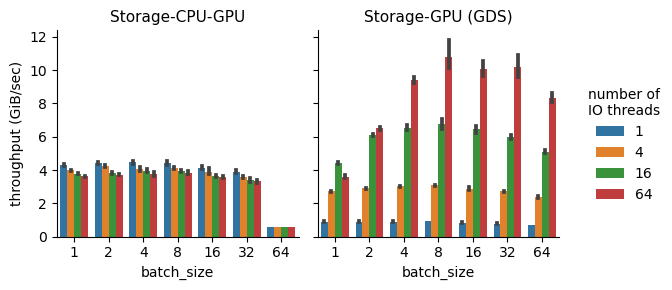

In [11]:
g = sns.FacetGrid(io_df, col="data transfer path", margin_titles=True)
g.set_titles(col_template="{col_name}", size=11)
g.map_dataframe(
    sns.barplot, x="batch_size", y="throughput (GiB/sec)", hue="ninterthreads",
    hue_order=sorted(io_df["ninterthreads"].unique()),
    palette=sns.color_palette(n_colors=io_df.ninterthreads.nunique())
)
g.add_legend(title="number of\nIO threads")
# g.figure.suptitle("Data transfer path")
# plt.tight_layout()
plt.savefig(f"img/dali-numpy-reader.pdf", format="pdf")
plt.show()